In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
def month_string_to_number(string):
    """ month_string_to_number takes a month and turns it into the 
    corresponding number
    args:
        :string - each item is a string

    returns:
        :(out) - the equivalent of the month's number
    """
    m = {
        'jan': 1,
        'feb': 2,
        'mar': 3,
        'apr':4,
         'may':5,
         'jun':6,
         'jul':7,
         'aug':8,
         'sep':9,
         'oct':10,
         'nov':11,
         'dec':12
        }
    s = string.strip()[:3].lower()

    try:
        out = m[s]
        return out
    except:
        raise ValueError('Not a month')



In [3]:
path = '/Users/afugere/Desktop/UVM Masters/GraduateSemester2/STAT330/FinalProject/'
path2 = '/Users/abigailhotaling/Documents/STAT_330_Project/Data/'

In [4]:
data = pd.read_csv(path2+ 'Electricity_Residential_Price_New_England.csv')

In [5]:
#data.columns = ['Date', 'Electricity Residential Price: New England cents per kilowatthour']
data.columns = ['Date', 'Electricity Price']
# I also changed the column name for now, just to be a little bit shorter 
dates = []
months = []
years = []
for entry in data['Date']:
    dates.append(entry.replace('-', ' '))
    data['Month and Year'] = pd.Series(dates)
    months.append(month_string_to_number(str(entry[0:-3])))
    years.append(entry[-2:])
    data['Month'] = pd.Series(months)
    data['Year'] = pd.Series(years)
    

In [6]:
updated_years = []
for y in data['Year']:
    if int(y) > 19:
        updated_years.append('19'+y)
    else:
        updated_years.append('20'+y)
    data['Year'] = pd.Series(updated_years)

In [7]:
data['Day'] = [1]*len(data)

In [8]:
data['Datetime'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
data.iloc[:] = data.iloc[::-1].values

In [10]:
data.head()

,Date,Electricity Price,Month and Year,Month,Year,Day,Datetime
0,Dec-96,12.30,Dec 96,12,1996,1,1996-12-01
1,Jan-97,11.81,Jan 97,1,1997,1,1997-01-01
2,Feb-97,11.73,Feb 97,2,1997,1,1997-02-01
3,Mar-97,12.07,Mar 97,3,1997,1,1997-03-01
4,Apr-97,11.54,Apr 97,4,1997,1,1997-04-01


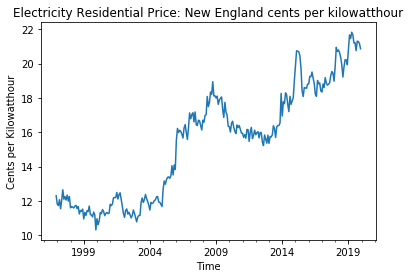

In [11]:
ax = data.plot(x = 'Datetime', y = 'Electricity Price', 
               title = 'Electricity Residential Price: New England cents per kilowatthour', legend = False)
ax.set_xlabel('Time')
ax.set_ylabel('Cents per Kilowatthour')
ax.format_xdata = mdates.DateFormatter('%Y-%m')

## Seasonal Subseries Plots

In [12]:
groups = data.groupby('Month')
months = pd.concat([pd.DataFrame({name:group['Electricity Price'].values}) for name, group in groups],
                   ignore_index=True, axis=1)
     
months.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

Text(0.5,1,'Seasonality Subplot')

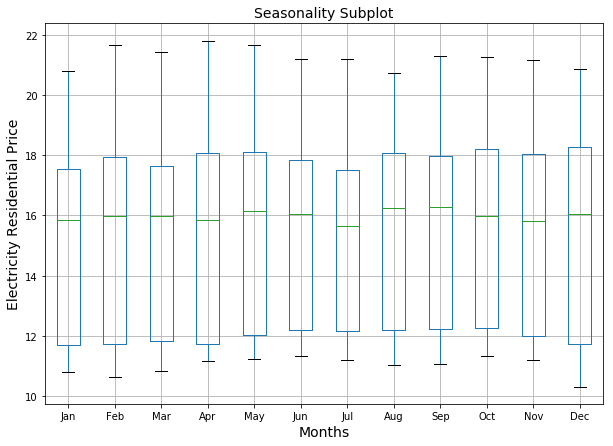

In [13]:
ax = months.boxplot(figsize = (10, 7))
ax.set_xlabel("Months", fontsize=14)
ax.set_ylabel('Electricity Residential Price', fontsize=14)
ax.set_title('Seasonality Subplot', fontsize=14)

There doesn't appear to be a large seasonal trend, that I can see at least. Let me know what you think. 

## Autoregressive Models

As some preliminary work lets fit some AR models. 
Some things to check:
    - Autocorrelation
    - Lag
    - Residuals
    
I completed this section following this link: https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/

### Lag Plot

There is a clear linear relationship between the previous month and the next month. 

/Users/abigailhotaling/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.
  


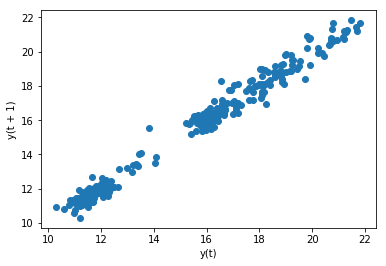

In [14]:
from pandas.tools.plotting import lag_plot
lag_plot(data['Electricity Price'])

In [15]:
dataframe = pd.concat([data['Electricity Price'].shift(1), data['Electricity Price']], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.991049
t+1  0.991049  1.000000


The correlation is very high, 0.99

/Users/abigailhotaling/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  


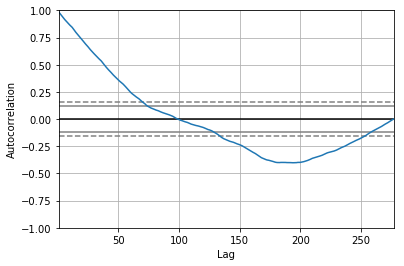

In [16]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(data['Electricity Price'])


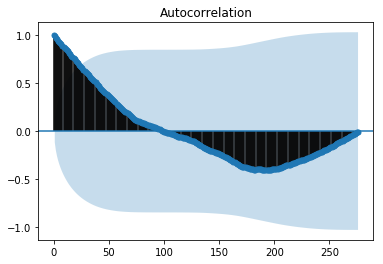

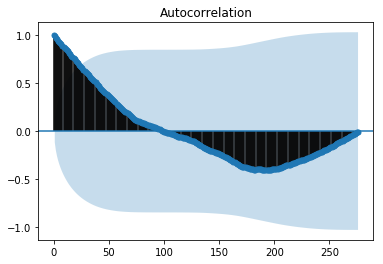

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data['Electricity Price'])


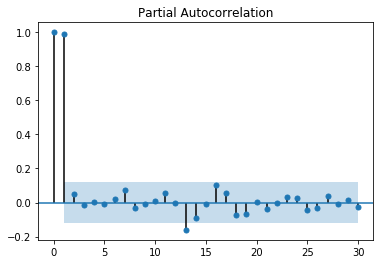

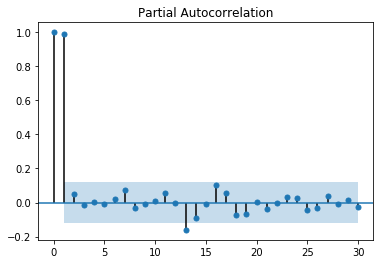

In [18]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data['Electricity Price'], lags=30)


### Percistance Model
The simplest model that we could use to make predictions would be to persist the last observation. We can call this a persistence model and it provides a baseline of performance for the problem that we can use for comparison with an autoregression model.

Right now we will try to predict the last 6 months of the data set. The predictions are made using a walk-forward validation model so that we can persist the most recent observations for the next month. This means that we are not making a 6-month forecast, but 6 1-month forecasts.

Test MSE: 0.103


Text(0,0.5,'Electricity Price')

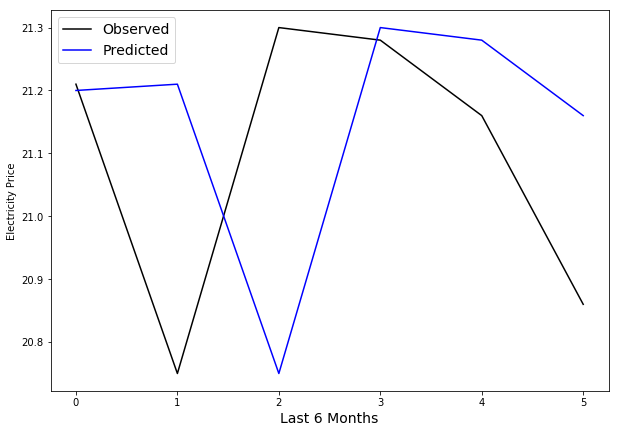

In [19]:
from sklearn.metrics import mean_squared_error
# create lagged dataset
values = data['Electricity Price']
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-6], X[len(X)-6:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model
def model_persistence(x):
    return x

# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)

# plot predictions vs expected
fig, ax = plt.subplots(figsize = (10,7))
ax.plot(test_y, color = 'black', label = 'Observed')
ax.plot(predictions, color = 'blue', label = 'Predicted')
ax.legend(loc='best', fontsize = 14)
ax.set_xlabel('Last 6 Months', fontsize=14)
ax.set_ylabel('Electricity Price')

### Auto Regressive Model

An autoregression model is a linear regression model that uses lagged variables as input variables.

We could calculate the linear regression model manually using the LinearRegession class in scikit-learn and manually specify the lag input variables to use.

Alternately, the statsmodels library provides an autoregression model that automatically selects an appropriate lag value using statistical tests and trains a linear regression model. It is provided in the AR class.

We can use this model by first creating the model AR() and then calling fit() to train it on our dataset. This returns an ARResult object.

Once fit, we can use the model to make a prediction by calling the predict() function for a number of observations in the future. This creates 1 6-month forecast, which is different from the persistence example above.



Lag: 15
Coefficients: [ 0.12765213  0.79470602  0.16340126  0.0323957   0.03377095 -0.07282813
 -0.0231596   0.01361711  0.01331805  0.0206323  -0.04791003  0.17848284
  0.24151398 -0.22713419 -0.09571671 -0.03116612]
predicted=20.894633, expected=21.210000
predicted=20.622298, expected=20.750000
predicted=20.761549, expected=21.300000
predicted=20.895841, expected=21.280000
predicted=20.839552, expected=21.160000
predicted=20.833611, expected=20.860000
Test MSE: 0.109


Text(0,0.5,'Electricity Price')

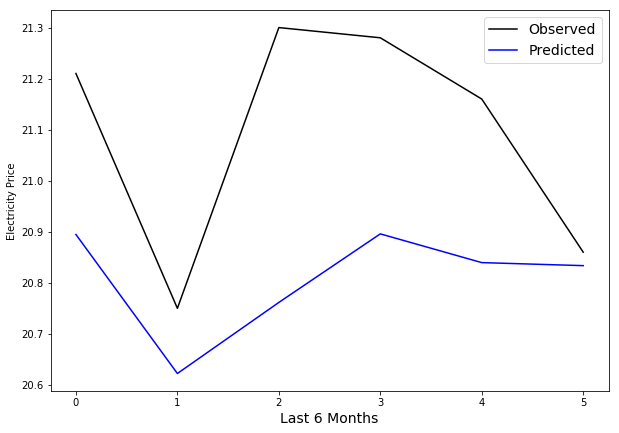

In [20]:
from statsmodels.tsa.ar_model import AR
X = data['Electricity Price'].values
train, test = X[1:len(X)-6], X[len(X)-6:]
# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot results
fig, ax = plt.subplots(figsize = (10,7))
ax.plot(test, color = 'black', label = 'Observed')
ax.plot(predictions, color = 'blue', label = 'Predicted')
ax.legend(loc='best', fontsize = 14)
ax.set_xlabel('Last 6 Months', fontsize=14)
ax.set_ylabel('Electricity Price')

predicted=20.894633, expected=21.210000
predicted=20.872922, expected=20.750000
predicted=20.914565, expected=21.300000
predicted=21.354835, expected=21.280000
predicted=21.247616, expected=21.160000
predicted=21.149834, expected=20.860000
Test MSE: 0.060


Text(0,0.5,'Electricity Price')

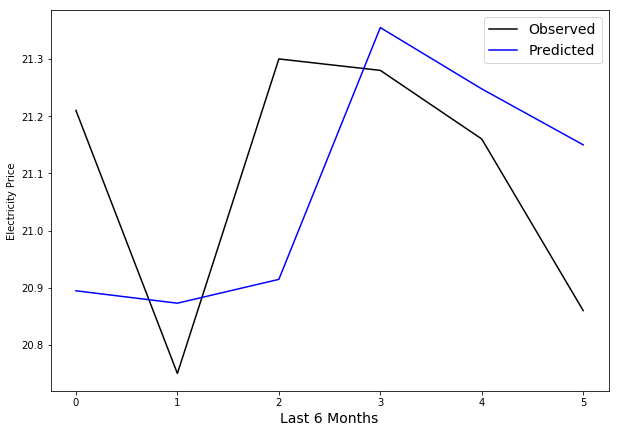

In [21]:
# split dataset
X = data['Electricity Price'].values
train, test = X[1:len(X)-6], X[len(X)-6:]
# train autoregression
model = AR(train)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot results
fig, ax = plt.subplots(figsize = (10,7))
ax.plot(test, color = 'black', label = 'Observed')
ax.plot(predictions, color = 'blue', label = 'Predicted')
ax.legend(loc='best', fontsize = 14)
ax.set_xlabel('Last 6 Months', fontsize=14)
ax.set_ylabel('Electricity Price')

Lag: 15
Coefficients: [ 0.20960989  0.76048149  0.20241366  0.05519662  0.04438382 -0.13270304
 -0.00953787 -0.02058549  0.05437423  0.04177482 -0.06102858  0.19411963
  0.19368693 -0.149225   -0.09456406 -0.09139702]
Test MSE: 3.759


Text(0,0.5,'Electricity Price')

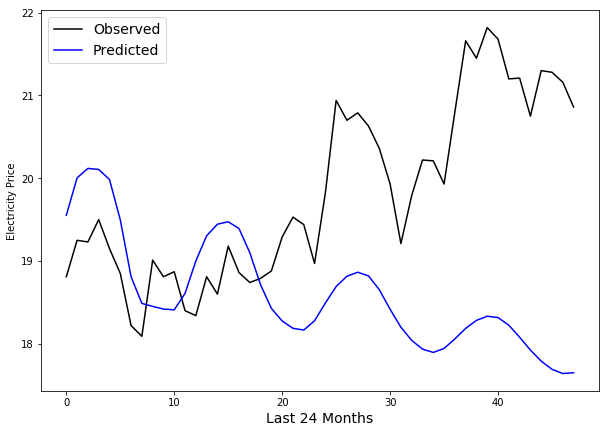

In [22]:
from statsmodels.tsa.ar_model import AR
X = data['Electricity Price'].values
train, test = X[1:len(X)-48], X[len(X)-48:]
# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
#for i in range(len(predictions)):
    #print('predicted=%f, expected=%f' % (predictions[i], test[i]))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot results
fig, ax = plt.subplots(figsize = (10,7))
ax.plot(test, color = 'black', label = 'Observed')
ax.plot(predictions, color = 'blue', label = 'Predicted')
ax.legend(loc='best', fontsize = 14)
ax.set_xlabel('Last 24 Months', fontsize=14)
ax.set_ylabel('Electricity Price')

Test MSE: 0.190


Text(0,0.5,'Electricity Price')

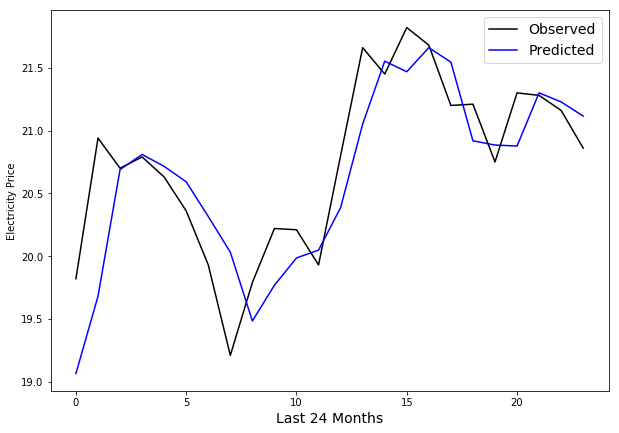

In [23]:
# split dataset
X = data['Electricity Price'].values
train, test = X[1:len(X)-24], X[len(X)-24:]
# train autoregression
model = AR(train)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot results
fig, ax = plt.subplots(figsize = (10,7))
ax.plot(test, color = 'black', label = 'Observed')
ax.plot(predictions, color = 'blue', label = 'Predicted')
ax.legend(loc='best', fontsize = 14)
ax.set_xlabel('Last 24 Months', fontsize=14)
ax.set_ylabel('Electricity Price')

### Moving Average Model 
https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/

Test MSE: 0.245


Text(0,0.5,'Electricity Price')

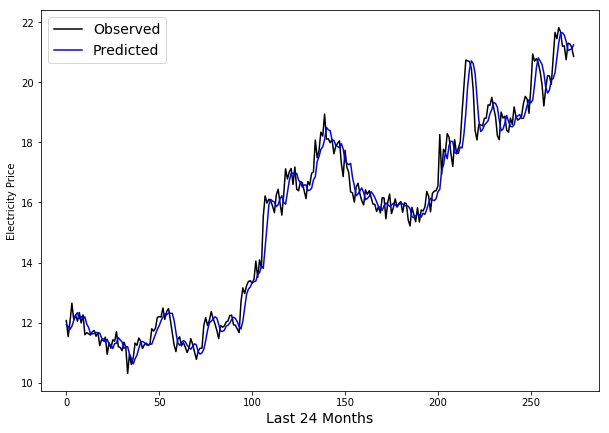

In [24]:
# split dataset
X = data['Electricity Price'].values
window = 3
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()
# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = np.mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
fig, ax = plt.subplots(figsize = (10,7))
ax.plot(test, color = 'black', label = 'Observed')
ax.plot(predictions, color = 'blue', label = 'Predicted')
ax.legend(loc='best', fontsize = 14)
#ax.set_xlim((50,100))
ax.set_xlabel('Last 24 Months', fontsize=14)
ax.set_ylabel('Electricity Price')

## ARIMA

Good References: 

    Modeling ARIMA:
    https://onlinecourses.science.psu.edu/stat510/node/64/
    
    Stationarity:
    https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/
  
    Python Examples:
    https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
    
So far the best model is ARIMA with AR(1), difference 1 and no MA 

In [46]:
from statsmodels.tsa.arima_model import ARIMA

In [47]:
#order : iterable
    #The (p,d,q) order of the model for the number of AR parameters,
    #differences, and MA parameters to use.

                              ARMA Model Results                              
Dep. Variable:      Electricity Price   No. Observations:                  277
Model:                     ARMA(1, 0)   Log Likelihood                -163.590
Method:                       css-mle   S.D. of innovations              0.433
Date:                Tue, 13 Nov 2018   AIC                            333.181
Time:                        17:59:54   BIC                            344.053
Sample:                             0   HQIC                           337.543
                                                                              
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      16.0079      2.630      6.087      0.000      10.854      21.162
ar.L1.Electricity Price     0.9930      0.006    159.258      0.000       0.981       1.005


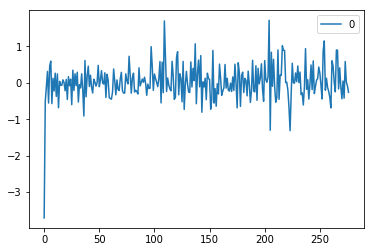

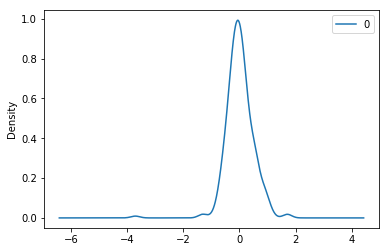

                0
count  277.000000
mean     0.013292
std      0.487305
min     -3.707928
25%     -0.240475
50%     -0.008937
75%      0.261272
max      1.713790


In [48]:
# fit model AR(1)
model = ARIMA(data['Electricity Price'], order=(1,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

                              ARIMA Model Results                              
Dep. Variable:     D.Electricity Price   No. Observations:                  276
Model:                  ARIMA(1, 1, 0)   Log Likelihood                -157.435
Method:                        css-mle   S.D. of innovations              0.428
Date:                 Tue, 13 Nov 2018   AIC                            320.869
Time:                         17:59:55   BIC                            331.730
Sample:                              1   HQIC                           325.228
                                                                               
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.0314      0.022      1.401      0.162      -0.013       0.075
ar.L1.D.Electricity Price    -0.1497      0.060     -2.511      0.013      -0.

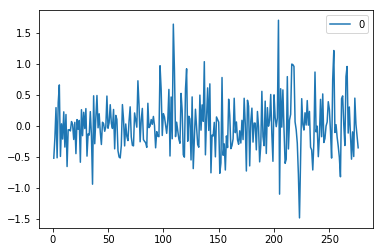

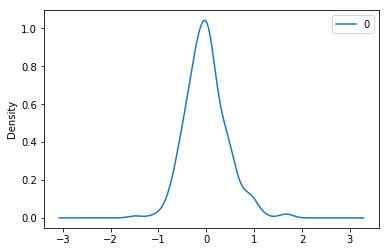

                0
count  276.000000
mean    -0.000283
std      0.428832
min     -1.482423
25%     -0.277992
50%     -0.020031
75%      0.228052
max      1.697835


In [49]:
# fit model AR(1), difference 1
model = ARIMA(data['Electricity Price'], order=(1,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

                              ARIMA Model Results                              
Dep. Variable:     D.Electricity Price   No. Observations:                  276
Model:                  ARIMA(2, 1, 0)   Log Likelihood                -157.269
Method:                        css-mle   S.D. of innovations              0.428
Date:                 Tue, 13 Nov 2018   AIC                            322.537
Time:                         17:59:57   BIC                            337.019
Sample:                              1   HQIC                           328.349
                                                                               
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.0315      0.022      1.456      0.147      -0.011       0.074
ar.L1.D.Electricity Price    -0.1550      0.060     -2.571      0.011      -0.

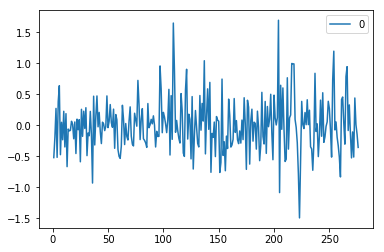

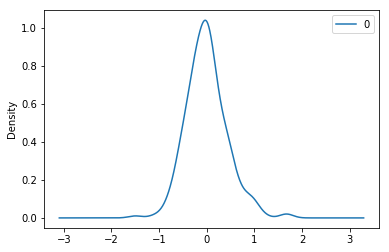

                0
count  276.000000
mean    -0.000363
std      0.428574
min     -1.495914
25%     -0.282095
50%     -0.023040
75%      0.228008
max      1.697633


In [50]:
# fit model AR(2), difference 1, MA 0
model = ARIMA(data['Electricity Price'], order=(2,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

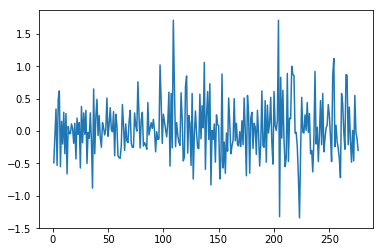

In [36]:
difference = data['Electricity Price'] - data['Electricity Price'].shift(1)
plt.plot(difference) # there is nonconstant variance --> needs a transformation?

In [37]:
price_log = np.log(data['Electricity Price'])
difference_log = price_log - price_log.shift(1)

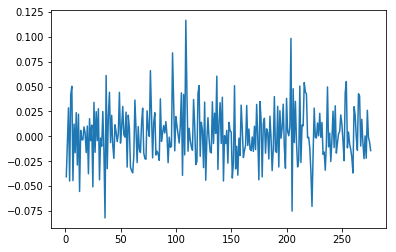

In [38]:
plt.plot(difference_log) # log transformation helps the variance a little (maybe hard to tell, need to do a test )